In [94]:
import pandas as pd
import numpy as np
from networkx import Graph, write_adjlist
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from ela_feature_definition import ela_feature_names
from networkx.algorithms.dominating import dominating_set
from networkx.algorithms.mis import maximal_independent_set

In [3]:
from dom_mis import *

In [117]:
similarity_thresholds=[0.5,0.7,0.9,0.95,0.97]
id_columns=['suite','fid', 'iid']

In [118]:
all_results=pd.DataFrame()
produced_instances_statistics=[]
for na_handling_setting_name in ['dropna']:
    ela_representation_df = pd.read_csv(f'data/aggregated_ela_representation_{na_handling_setting_name}.csv', index_col=[0,1,2])
    s = cosine_similarity(ela_representation_df.values,ela_representation_df.values)
    similarity_df=pd.DataFrame(s,index=ela_representation_df.index,columns=ela_representation_df.index)
    
    for min_similarity_threshold in similarity_thresholds:
        print(f'missing value handling: {na_handling_setting_name} THRESHOLD: {min_similarity_threshold}')
        g=generate_graph_from_similarity_matrix(similarity_df, min_similarity_threshold)
        print(f' -node count: {len(g.nodes)}')
        print(f' -edge count: {len(g.edges)}')
        for algorithm_name in ['dominant','mis']:
            instances_produced=[]
            for run_id in range(0,30):
                result_directory=os.path.join('results',na_handling_setting_name,algorithm_name)
                result_file_name=os.path.join(result_directory,f'{min_similarity_threshold}_{run_id}.csv')
                result_df = pd.read_csv(result_file_name,index_col=[0,1,2])
                result_df['run_id']=run_id
                result_df['algorithm_name']=algorithm_name
                result_df['min_similarity_threshold']=min_similarity_threshold
                result_df['na_handling_setting_name']=na_handling_setting_name
                all_results=all_results.append(result_df)
                instances_produced.append(result_df.shape[0])
                
            instances_produced=np.array(instances_produced)
            algorithm_config_stats = {'edge count': len(g.edges),
                                      'min': instances_produced.min(),
                                          'max': instances_produced.max(),
                                          'mean': round(instances_produced.mean(),2),
                                     'algorithm': 'DS' if algorithm_name=='dominant' else 'MIS',
                                     'min similarity threshold': min_similarity_threshold}
            produced_instances_statistics.append(algorithm_config_stats)
            for stat_name in ['min','max','mean']:
                print(f' -{algorithm_name} {stat_name}: {algorithm_config_stats[stat_name]}')
            
        print()

missing value handling: dropna THRESHOLD: 0.5
 -node count: 221
 -edge count: 20821
 -dominant min: 2
 -dominant max: 4
 -dominant mean: 3.3
 -mis min: 3
 -mis max: 4
 -mis mean: 3.37

missing value handling: dropna THRESHOLD: 0.7
 -node count: 221
 -edge count: 19940
 -dominant min: 5
 -dominant max: 8
 -dominant mean: 7.07
 -mis min: 5
 -mis max: 8
 -mis mean: 6.9

missing value handling: dropna THRESHOLD: 0.9
 -node count: 221
 -edge count: 19119
 -dominant min: 11
 -dominant max: 12
 -dominant mean: 11.43
 -mis min: 11
 -mis max: 13
 -mis mean: 11.47

missing value handling: dropna THRESHOLD: 0.95
 -node count: 221
 -edge count: 17460
 -dominant min: 16
 -dominant max: 18
 -dominant mean: 17.37
 -mis min: 16
 -mis max: 19
 -mis mean: 17.27

missing value handling: dropna THRESHOLD: 0.97
 -node count: 221
 -edge count: 15116
 -dominant min: 20
 -dominant max: 24
 -dominant mean: 22.13
 -mis min: 21
 -mis max: 24
 -mis mean: 22.63



In [121]:
produced_instances_statistics_df = pd.DataFrame.from_records(produced_instances_statistics).set_index(['min similarity threshold','edge count','algorithm'])

In [122]:
produced_instances_statistics_df.to_latex('produced_instances_statistics')

In [129]:
df = pd.read_csv('data/ela.csv', index_col=[0])

In [42]:
id_cluster = df[['cluster']+id_columns].drop_duplicates()

In [47]:
all_results_copy=all_results.reset_index()

In [49]:
all_results_copy.columns

Index(['level_0', 'suite', 'fid', 'iid', 'run_id', 'algorithm_name',
       'min_similarity_threshold', 'na_handling_setting_name'],
      dtype='object')

In [52]:
all_results_copy=all_results_copy.merge(id_cluster, left_on=id_columns, right_on=id_columns)

In [61]:
all_results_grouped = all_results_copy.groupby(['na_handling_setting_name','min_similarity_threshold','algorithm_name','run_id','cluster']).count()
all_results_grouped['fid'].to_csv('cluster_dist.csv')

In [65]:
all_results_grouped = all_results_copy[['na_handling_setting_name','min_similarity_threshold','algorithm_name','run_id','cluster']].drop_duplicates().groupby(['na_handling_setting_name','min_similarity_threshold','algorithm_name','run_id']).count()
print(all_results_grouped)
all_results_grouped['cluster'].to_csv('number of unique clusters.csv')

                                                                         cluster
na_handling_setting_name min_similarity_threshold algorithm_name run_id         
dropna                   0.50                     dominant       0             6
                                                                 1             6
                                                                 2             6
                                                                 3             8
                                                                 4             5
...                                                                          ...
fillna                   0.95                     mis            25           14
                                                                 26           16
                                                                 27           16
                                                                 28           19
                            

In [126]:
aggregated_ela_df=pd.read_csv('data/aggregated_ela_representation_dropna.csv')

In [136]:
ela_representation_df = pd.read_csv(f'data/aggregated_ela_representation_dropna.csv', index_col=[0,1,2])
s = cosine_similarity(ela_representation_df.values,ela_representation_df.values)
similarity_df=pd.DataFrame(s,index=ela_representation_df.index,columns=ela_representation_df.index)

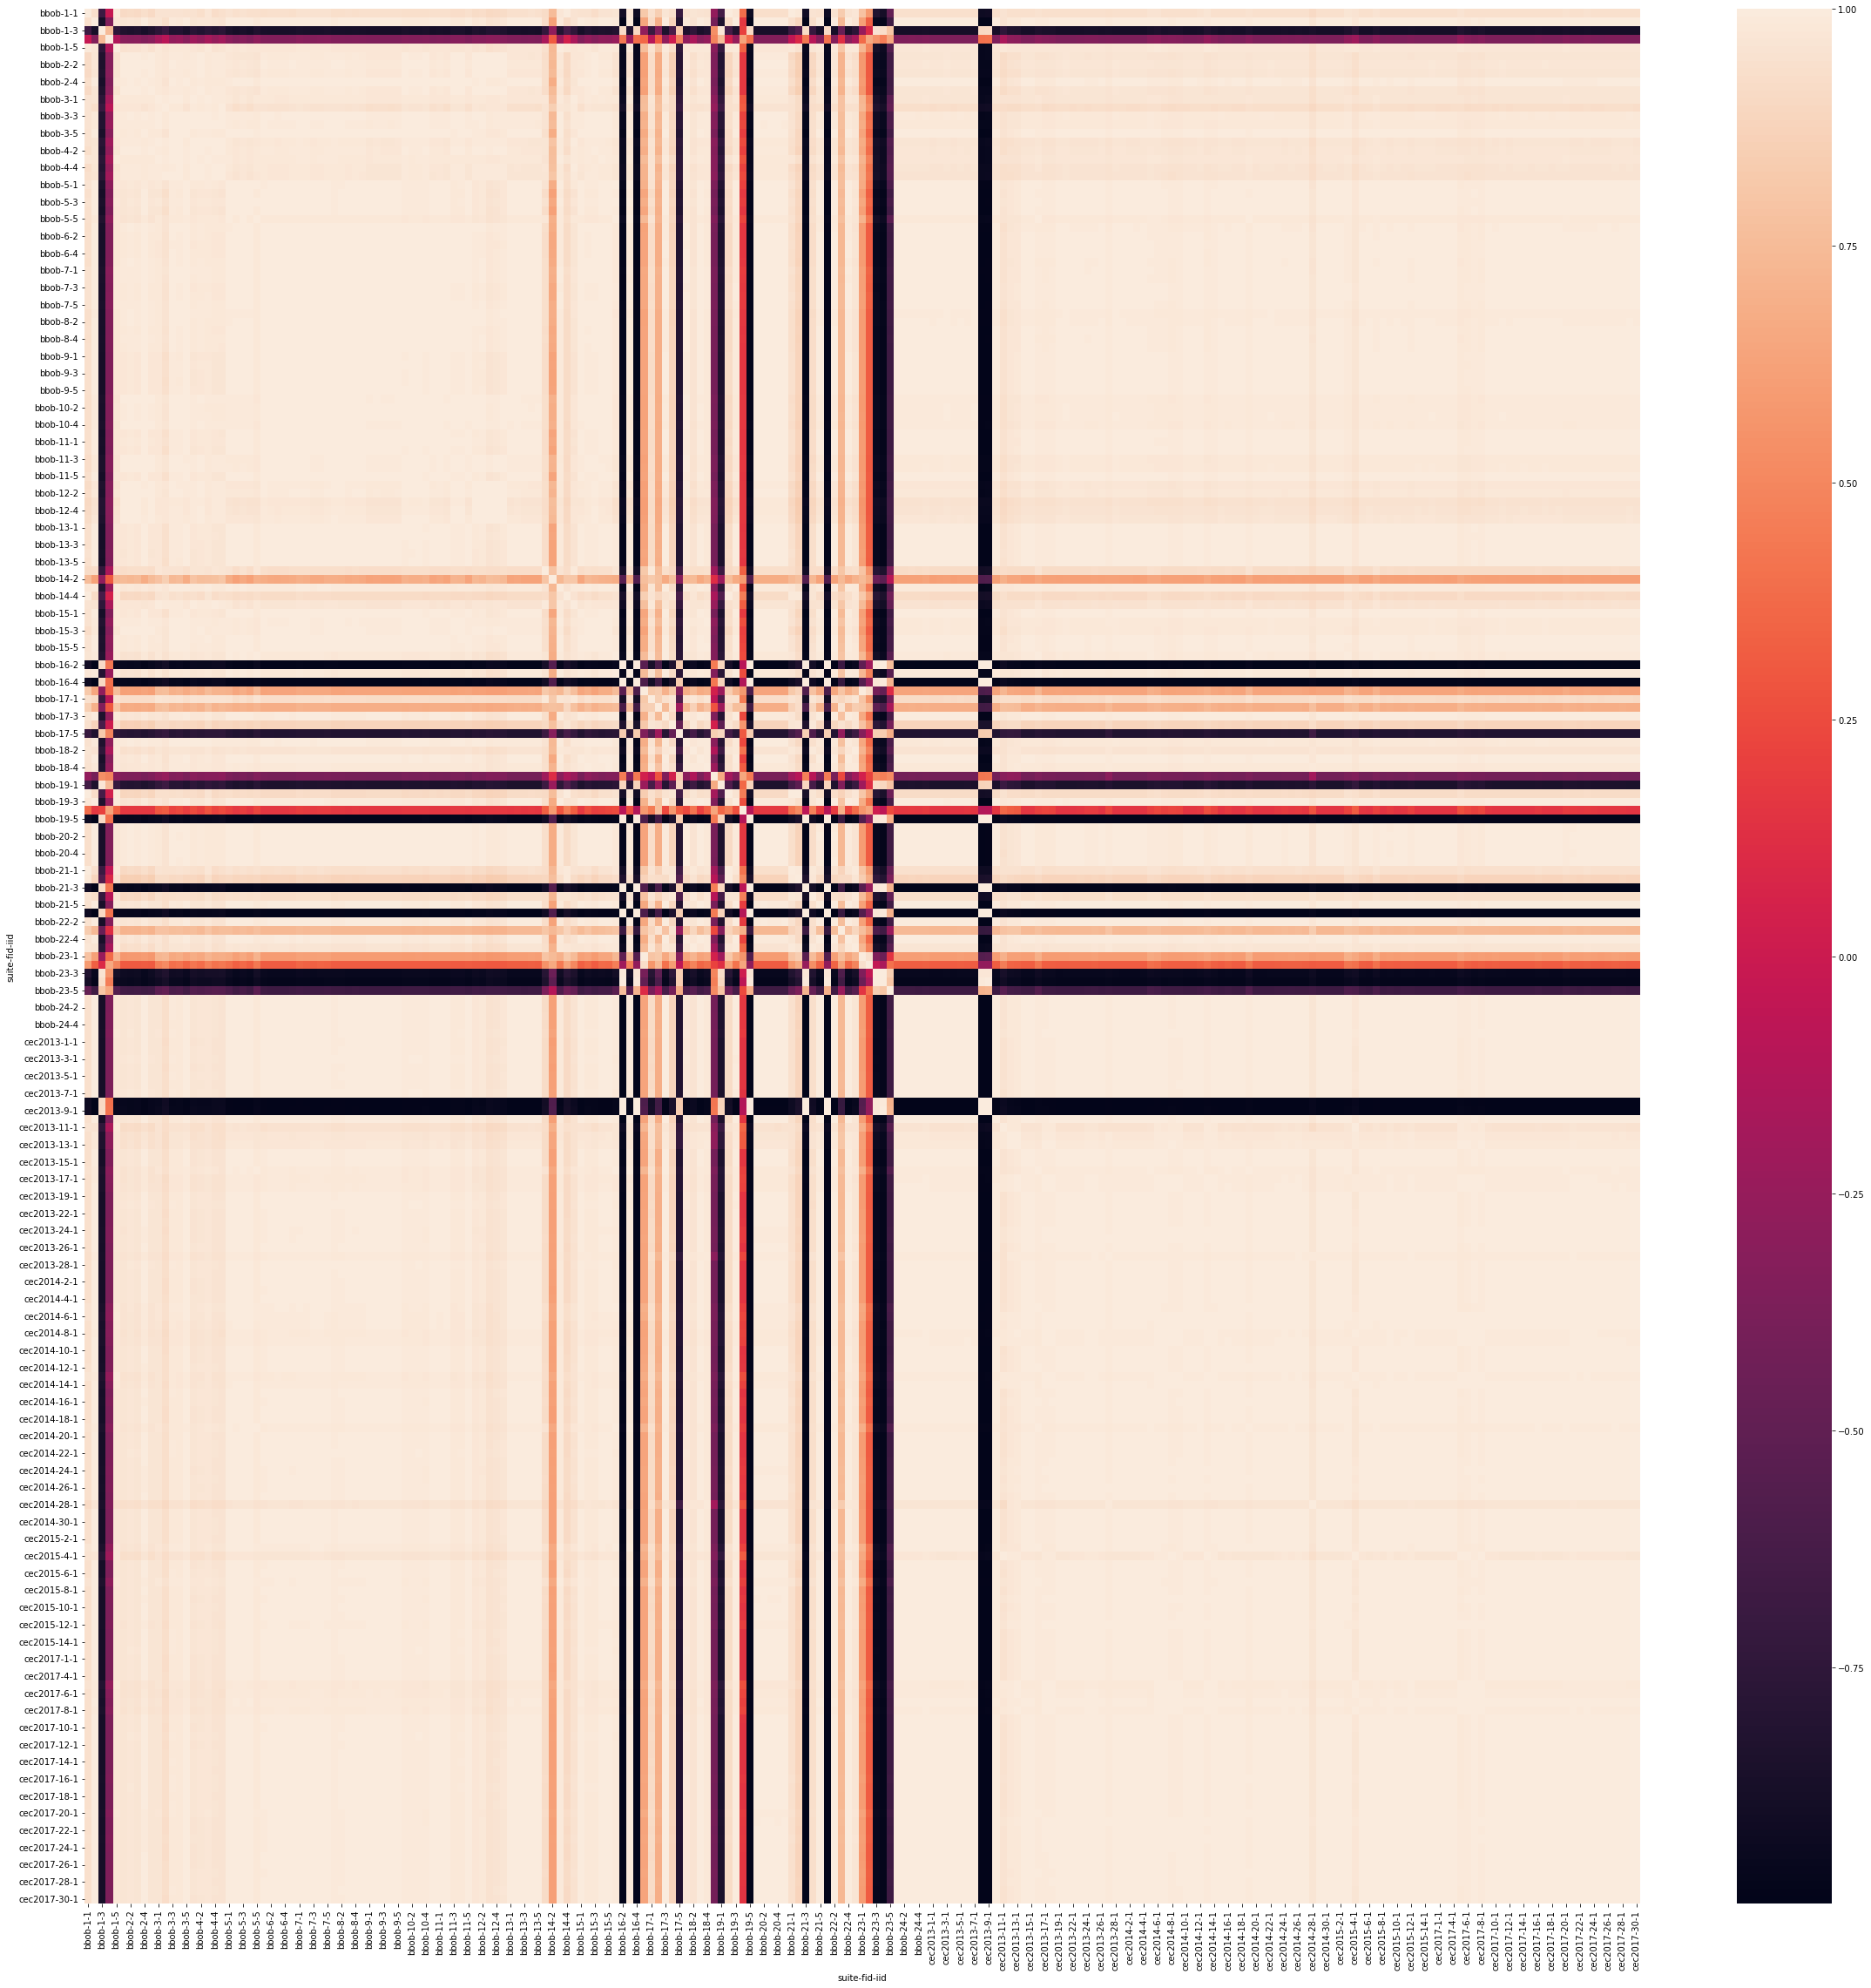

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
sns.heatmap(similarity_df)
plt.savefig('cosine_similarity_heatmap.pdf')